In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.calibration import calibration_curve
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"

In [2]:
data = pd.read_csv("dataset.csv")

In [3]:
data.head()

,id,title,genre,original_language,overview,popularity,release_date,vote_average,vote_count
0,278,The Shawshank Redemption,"Drama,Crime",en,Framed in the 1940s for the double murder of h...,94.075,1994-09-23,8.7,21862
1,19404,Dilwale Dulhania Le Jayenge,"Comedy,Drama,Romance",hi,"Raj is a rich, carefree, happy-go-lucky second...",25.408,1995-10-19,8.7,3731
2,238,The Godfather,"Drama,Crime",en,"Spanning the years 1945 to 1955, a chronicle o...",90.585,1972-03-14,8.7,16280
3,424,Schindler's List,"Drama,History,War",en,The true story of how businessman Oskar Schind...,44.761,1993-12-15,8.6,12959
4,240,The Godfather: Part II,"Drama,Crime",en,In the continuing saga of the Corleone crime f...,57.749,1974-12-20,8.6,9811


In [4]:
len(data)

10000

In [57]:
data['genre'] = data['genre'].fillna(data['genre'].mode()[0])

In [56]:
data['genre_list'] = data['genre'].apply(lambda x: x.split(','))

In [8]:
data['genre_list'].tail()

9995                         [Action, Adventure, Fantasy]
9996    [Action, TV Movie, Science Fiction, Comedy, Ad...
9997                       [Action, Science Fiction, War]
9998                  [Adventure, Fantasy, Action, Drama]
9999                            [Thriller, Action, Crime]
Name: genre_list, dtype: object

In [9]:
data = data.reset_index(drop=True)

In [10]:
mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb.fit_transform(data['genre_list']), columns=mlb.classes_)

data = data.join(genre_encoded)

In [11]:
data.columns

Index(['id', 'title', 'genre', 'original_language', 'overview', 'popularity',
       'release_date', 'vote_average', 'vote_count', 'genre_list', 'Action',
       'Adventure', 'Animation', 'Comedy', 'Crime', 'Drama', 'Family',
       'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance',
       'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western'],
      dtype='object')

In [12]:
data[['Action', 'Adventure',
       'Animation', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie',
       'Thriller', 'War', 'Western']].tail(5)

,Action,Adventure,Animation,Comedy,Crime,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
9980,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9981,1,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0
9982,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
9983,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
9984,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [13]:
label_encoder = LabelEncoder()
data['original_language_encoded'] = label_encoder.fit_transform(data['original_language'])

In [14]:
data['release_date'] = pd.to_datetime(data['release_date'], errors='coerce')

data['release_year'] = data['release_date'].dt.year
data['release_month'] = data['release_date'].dt.month
data['release_day'] = data['release_date'].dt.day

In [15]:
data.columns

Index(['id', 'title', 'genre', 'original_language', 'overview', 'popularity',
       'release_date', 'vote_average', 'vote_count', 'genre_list', 'Action',
       'Adventure', 'Animation', 'Comedy', 'Crime', 'Drama', 'Family',
       'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance',
       'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western',
       'original_language_encoded', 'release_year', 'release_month',
       'release_day'],
      dtype='object')

In [16]:
cols = ['popularity', 'vote_count', 'Action',
       'Adventure', 'Animation', 'Comedy', 'Crime', 'Drama', 'Family',
       'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance',
       'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western',
       'original_language_encoded', 'release_year', 'release_month',
       'release_day']
X = data[cols].values

In [17]:
X

array([[9.4075e+01, 2.1862e+04, 0.0000e+00, ..., 1.9940e+03, 9.0000e+00,
        2.3000e+01],
       [2.5408e+01, 3.7310e+03, 0.0000e+00, ..., 1.9950e+03, 1.0000e+01,
        1.9000e+01],
       [9.0585e+01, 1.6280e+04, 0.0000e+00, ..., 1.9720e+03, 3.0000e+00,
        1.4000e+01],
       ...,
       [1.8333e+01, 3.3200e+02, 1.0000e+00, ..., 1.9900e+03, 1.2000e+01,
        1.4000e+01],
       [1.5159e+01, 6.6800e+02, 1.0000e+00, ..., 2.0070e+03, 1.1000e+01,
        2.9000e+01],
       [1.6482e+01, 2.2100e+02, 1.0000e+00, ..., 2.0190e+03, 5.0000e+00,
        3.1000e+01]])

In [18]:
def categorize_vote_average(v):
    """
    Returns an integer for the category:
      0 => bad
      1 => good
    """
    if v < 6.5:
        return 0  # bad
    else:
        return 1  # good

data['vote_label'] = data['vote_average'].apply(categorize_vote_average)
y = data['vote_label']

In [19]:
len(X), len(y)

(9985, 9985)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

## Logistic Regression

In [21]:
class LogisticRegression_fct:
    def __init__(self, lr=0.01, n_iter=1000, penalty="l2", C=1.0, batch_size=None, early_stopping=True, tol=1e-4):
        """
        Robust Logistic Regression Model with Overfitting Prevention
        - lr: Learning rate
        - n_iter: Number of iterations
        - penalty: 'l2' (Ridge), 'l1' (Lasso), or None (No regularization)
        - C: Inverse of regularization strength (higher = weaker regularization)
        - batch_size: Mini-batch size for SGD (None = full batch)
        - early_stopping: Stops training if validation loss increases
        - tol: Tolerance for early stopping (stops if loss doesn't improve)
        """
        self.lr = lr
        self.n_iter = n_iter
        self.penalty = penalty
        self.C = C
        self.batch_size = batch_size
        self.early_stopping = early_stopping
        self.tol = tol
        self.theta_ = None

    @staticmethod
    def sigmoid(z):
        """ Numerically stable sigmoid function """
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y, validation_split=0.2):
        """
        Train Logistic Regression with Mini-batch SGD and Early Stopping
        """
        X = (X - np.mean(X, axis=0)) / (np.std(X, axis=0) + 1e-8)

        split_idx = int(len(X) * (1 - validation_split))
        X_train, X_val = X[:split_idx], X[split_idx:]
        y_train, y_val = y[:split_idx], y[split_idx:]

        m, n = X_train.shape
        X1_train = np.c_[np.ones((m, 1)), X_train]
        self.theta_ = np.zeros(n + 1)

        best_loss = float("inf")
        no_improve_count = 0

        for _ in range(self.n_iter):
            if self.batch_size and self.batch_size < m:
                idx = np.random.choice(m, self.batch_size, replace=False)
                X_batch, y_batch = X1_train[idx], y_train[idx]
            else:
                X_batch, y_batch = X1_train, y_train

            z = X_batch @ self.theta_
            y_pred = self.sigmoid(z)
            grad = (1 / len(y_batch)) * X_batch.T @ (y_pred - y_batch)

            if self.penalty == "l2":
                grad[1:] += (1 / self.C) * self.theta_[1:]  
            elif self.penalty == "l1":
                grad[1:] += (1 / self.C) * np.sign(self.theta_[1:])  

            self.theta_ -= self.lr * grad  

            if self.early_stopping:
                val_loss = self._compute_loss(X_val, y_val)
                if val_loss < best_loss - self.tol:
                    best_loss = val_loss
                    no_improve_count = 0
                else:
                    no_improve_count += 1

                if no_improve_count >= 5:  
                    break

        return self

    def _compute_loss(self, X, y):
        """ Compute Binary Cross-Entropy Loss """
        X1 = np.c_[np.ones((X.shape[0], 1)), X]
        z = X1 @ self.theta_
        y_pred = self.sigmoid(z)
        return -np.mean(y * np.log(y_pred + 1e-15) + (1 - y) * np.log(1 - y_pred + 1e-15))

    def predict_prob(self, X):
        """ Predict probabilities for class=1 """
        X = (X - np.mean(X, axis=0)) / (np.std(X, axis=0) + 1e-8)  
        X1 = np.c_[np.ones((X.shape[0], 1)), X]
        z = X1 @ self.theta_
        return self.sigmoid(z)

    def predict(self, X, threshold=0.5):
        """ Predict class labels (0 or 1) """
        return (self.predict_prob(X) >= threshold).astype(int)

    def score(self, X, y):
        """ Compute accuracy """
        return np.mean(self.predict(X) == y)

    def get_params(self, deep=True):
        """ Get model parameters for GridSearchCV & RandomizedSearchCV """
        return {"lr": self.lr, "n_iter": self.n_iter, "penalty": self.penalty, 
                "C": self.C, "batch_size": self.batch_size, "early_stopping": self.early_stopping, "tol": self.tol}

    def set_params(self, **params):
        """ Set model parameters for GridSearchCV & RandomizedSearchCV """
        for key, value in params.items():
            setattr(self, key, value)
        return self


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

param_dist = {
    "lr": loguniform(1e-4, 1),  
    "n_iter": [1000, 5000],  
    "penalty": ["l2", "l1"],  
    "C": loguniform(0.1, 10),  
    "batch_size": [None, 64, 128, 256],  
    "early_stopping": [True]  
}

rs_log_reg = RandomizedSearchCV(
    LogisticRegression_fct(),
    param_distributions=param_dist,
    n_iter=20,
    cv=10,  
    verbose=1,
    scoring="accuracy",
    n_jobs=-1,
    random_state=42
)

rs_log_reg.fit(X_train, y_train)

print("Best Parameters:", rs_log_reg.best_params_)
print("Best Score:", rs_log_reg.best_score_)

In [23]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    "lr": [0.001, 0.01, 0.1],  # Learning rate: 0.001, 0.01, 0.1, 1
    "n_iter": [2000, 3000, 4000, 5000, 10000, 20_000, 50_000]  # Number of iterations
} 

# Initialize GridSearchCV
gs_log_reg = GridSearchCV(
    LogisticRegression_fct(),
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    verbose=1,
    scoring="accuracy",
    n_jobs=-1
)

# Fit the model
gs_log_reg.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", gs_log_reg.best_params_)
print("Best Score:", gs_log_reg.best_score_)

Fitting 5 folds for each of 21 candidates, totalling 105 fits
Best Parameters: {'lr': 0.001, 'n_iter': 2000}
Best Score: 0.7084375977172468


In [24]:
print("Best Parameters:", gs_log_reg.best_params_)

print("Best Score:", gs_log_reg.best_score_)

Best Parameters: {'lr': 0.001, 'n_iter': 2000}
Best Score: 0.7084375977172468


In [25]:
lr_model = LogisticRegression_fct(**rs_log_reg.best_params_) 
lr_model.fit(X_train, y_train)

In [26]:
y_pred_lr = lr_model.predict(X_test)
y_prob_lr = lr_model.predict_prob(X_test)

In [27]:
import numpy as np

class DecisionTree_fct:
    def __init__(self, max_depth=None, min_samples_split=2):
        """
        Decision Tree Classifier
        - max_depth: Maximum depth of the tree (None = grow until all leaves are pure)
        - min_samples_split: Minimum samples required to split a node
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None
        self.n_features_ = None
        self.feature_importances_ = None  # Track Gini-based importances

    def fit(self, X, y):
        """ Train Decision Tree """
        self.n_features_ = X.shape[1]
        self.feature_importances_ = np.zeros(self.n_features_)
        
        data = np.column_stack((X, y))  # shape (m, n_features+1)
        self.tree = self._build_tree(data, depth=0)
        
        # Normalize importances to sum=1
        total_imp = self.feature_importances_.sum()
        if total_imp > 0:
            self.feature_importances_ /= total_imp

        return self

    def _build_tree(self, data, depth):
        """ Recursively build the decision tree """
        X = data[:, :-1]
        y = data[:, -1]
        
        node = {'impurity': self._gini(y), 'samples': len(y)}

        # Stopping criteria
        if (len(np.unique(y)) == 1 or
            (self.max_depth is not None and depth >= self.max_depth) or
            (len(y) < self.min_samples_split)):
            return self._create_leaf(y)

        best_feat, best_thresh, best_gini, best_split = self._best_split(data)
        if best_feat is None:
            return self._create_leaf(y)
        
        left_data, right_data = best_split

        # Compute impurity decrease (feature importance)
        w_left = len(left_data) / len(y)
        w_right = len(right_data) / len(y)
        left_imp = self._gini(left_data[:, -1])
        right_imp = self._gini(right_data[:, -1])
        children_impurity = w_left * left_imp + w_right * right_imp
        imp_dec = node['impurity'] - children_impurity
        self.feature_importances_[best_feat] += imp_dec

        node.update({
            'leaf': False, 'feature': best_feat, 'threshold': best_thresh,
            'left': self._build_tree(left_data, depth + 1),
            'right': self._build_tree(right_data, depth + 1)
        })

        return node

    def _create_leaf(self, y):
        """ Create a leaf node with class probabilities """
        num_ones = np.sum(y == 1)
        num_total = len(y)
        prob_1 = num_ones / num_total if num_total > 0 else 0
        return {'leaf': True, 'prediction': int(prob_1 >= 0.5), 'prob_1': prob_1, 'prob_0': 1 - prob_1}

    def _best_split(self, data):
        """ Find the best feature and threshold to split """
        X, y = data[:, :-1], data[:, -1]
        m, n = X.shape
        best_gini, best_feat, best_thresh, best_split = float('inf'), None, None, None

        for fidx in range(n):
            for t in np.unique(X[:, fidx]):  # Try all unique values as threshold
                left_data, right_data = data[data[:, fidx] <= t], data[data[:, fidx] > t]
                gini_val = self._weighted_gini(left_data[:, -1], right_data[:, -1])
                if gini_val < best_gini:
                    best_gini, best_feat, best_thresh, best_split = gini_val, fidx, t, (left_data, right_data)

        return best_feat, best_thresh, best_gini, best_split

    def _gini(self, y):
        """ Compute Gini Impurity """
        if len(y) == 0: return 0
        p = np.mean(y == 1)
        return 1 - p**2 - (1 - p)**2

    def _weighted_gini(self, y_left, y_right):
        """ Compute weighted Gini impurity """
        n_left, n_right = len(y_left), len(y_right)
        n_total = n_left + n_right
        return (n_left / n_total) * self._gini(y_left) + (n_right / n_total) * self._gini(y_right) if n_total else 0

    def predict_prob_row(self, row, node):
        """ Recursively predict probabilities for a single sample """
        if node.get('leaf', False):
            return np.array([node['prob_0'], node['prob_1']])
        return self.predict_prob_row(row, node['left'] if row[node['feature']] <= node['threshold'] else node['right'])

    def predict_proba(self, X):
        """ Predict probabilities for both classes (0 and 1) """
        return np.array([self.predict_prob_row(row, self.tree) for row in X])

    def predict(self, X, threshold=0.5):
        """ Predict class labels (0 or 1) based on probabilities """
        return np.argmax(self.predict_proba(X), axis=1)

    def score(self, X, y):
        """ Compute accuracy score (required for GridSearchCV) """
        return np.mean(self.predict(X) == y)

    def get_params(self, deep=True):
        """ Get model parameters for GridSearchCV """
        return {"max_depth": self.max_depth, "min_samples_split": self.min_samples_split}

    def set_params(self, **params):
        """ Set model parameters for GridSearchCV """
        for key, value in params.items():
            setattr(self, key, value)
        return self


In [ ]:
param_grid = {
    "max_depth": [3, 5, 10, 20, None],  
    "min_samples_split": [2, 10, 15, 20, 80] 
}

# Initialize GridSearchCV
gs_tree = GridSearchCV(
    DecisionTree_fct(),
    param_grid=param_grid,
    cv=5,  
    verbose=1,
    scoring="accuracy",
    n_jobs=-1
)

gs_tree.fit(X_train, y_train)

print("Best Parameters:", gs_tree.best_params_)
print("Best Score:", gs_tree.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


Best Parameters: {'max_depth': 10, 'min_samples_split': 80}
Best Score: 0.7428629086295252


In [29]:
dt_model = DecisionTree_fct(**gs_tree.best_params_)
dt_model.fit(X_train, y_train)

In [30]:
y_pred_dt = dt_model.predict(X_test)
y_prob_dt = dt_model.predict_proba(X_test)[:, 1]

In [31]:
def plot_learning_curve(estimator, X, y, label, color):
    """
    Plots a learning curve (train score vs. validation score)
    for a given estimator. Uses accuracy as scoring by default.
    """
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=5, scoring='accuracy', 
        shuffle=True,
        train_sizes=[0.1, 0.33, 0.55, 0.78, 1.], 
        random_state=42
    )
    
    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    
    plt.plot(train_sizes, train_mean, 'o-', label=f"{label} Train", color=color)
    plt.plot(train_sizes, val_mean, 'o--', label=f"{label} Validation", color=color)

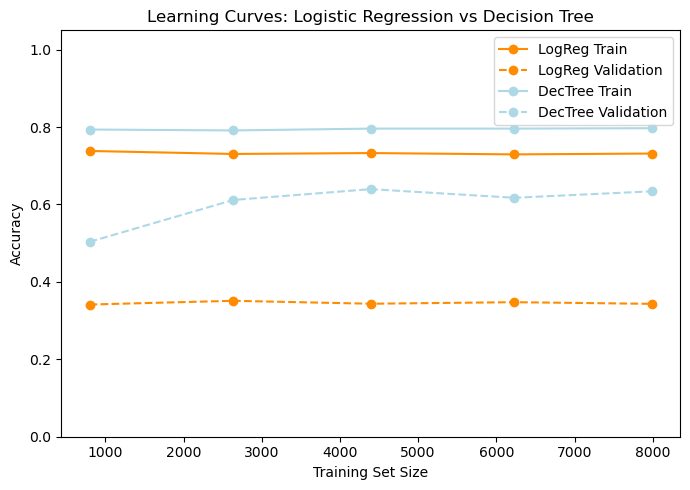

In [32]:
plt.figure(figsize=(7,5))

plot_learning_curve(lr_model, X, y, label="LogReg", color="darkorange")
plot_learning_curve(dt_model, X, y, label="DecTree", color="lightblue")

plt.title("Learning Curves: Logistic Regression vs Decision Tree")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.ylim([0,1.05])
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [33]:
def compute_metrics(y_true, y_pred, y_prob):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_val = auc(fpr, tpr)
    return acc, prec, rec, f1, fpr, tpr, auc_val

def plot_conf_mat(ax, cm, title, cmap):
    sns.heatmap(cm, annot=True, fmt='d', cbar=False, cmap=cmap, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

In [36]:
acc_lr, prec_lr, rec_lr, f1_lr, fpr_lr, tpr_lr, auc_lr = compute_metrics(y_test, y_pred_lr, y_prob_lr)
cm_lr = confusion_matrix(y_test, y_pred_lr)

acc_dt, prec_dt, rec_dt, f1_dt, fpr_dt, tpr_dt, auc_dt = compute_metrics(y_test, y_pred_dt, y_prob_dt)
cm_dt = confusion_matrix(y_test, y_pred_dt)

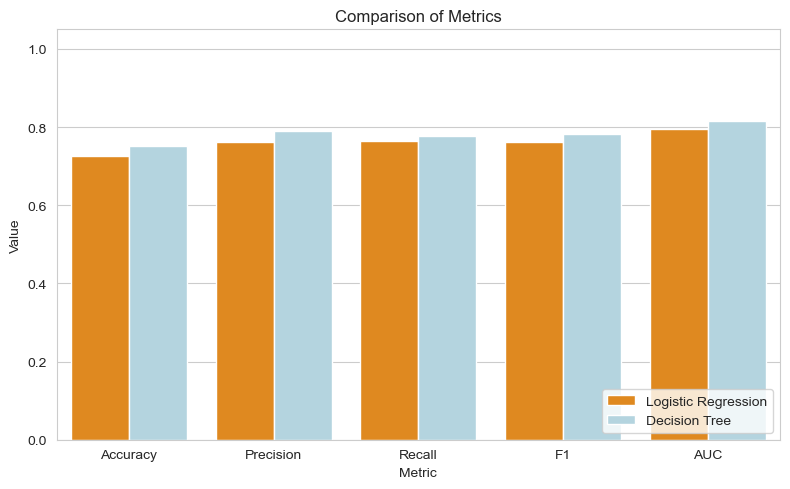

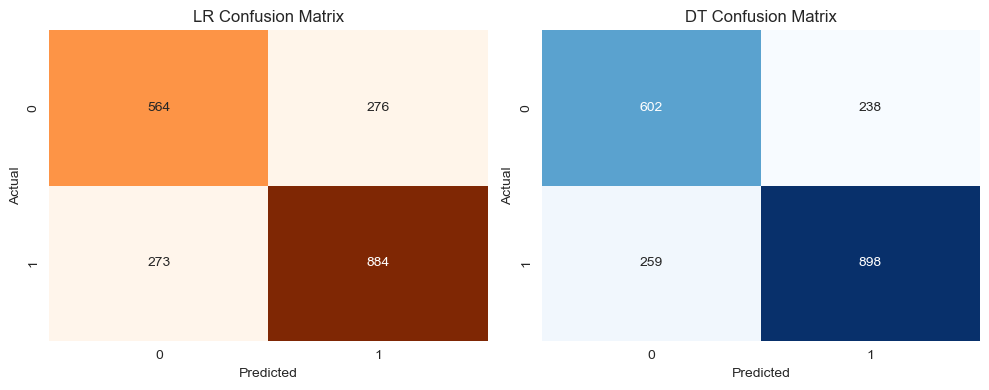

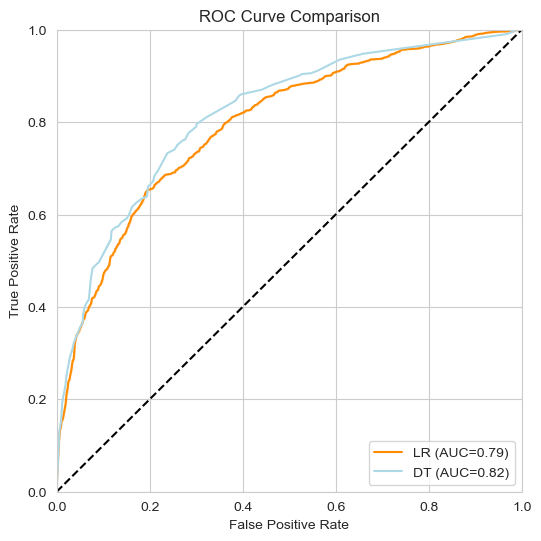

In [37]:
metrics = ["Accuracy", "Precision", "Recall", "F1", "AUC"]
lr_values = [acc_lr, prec_lr, rec_lr, f1_lr, auc_lr]
dt_values = [acc_dt, prec_dt, rec_dt, f1_dt, auc_dt]

df_metrics = pd.DataFrame({
    "Metric": metrics * 2,
    "Value": lr_values + dt_values,
    "Model": ["Logistic Regression"]*len(metrics) + ["Decision Tree"]*len(metrics)
})

sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
sns.barplot(data=df_metrics, x="Metric", y="Value", hue="Model",
            palette=["darkorange","lightblue"])
plt.ylim(0,1.05)
plt.title("Comparison of Metrics")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(10,4))


plot_conf_mat(axes[0], cm_lr, "LR Confusion Matrix", "Oranges")
plot_conf_mat(axes[1], cm_dt, "DT Confusion Matrix", "Blues")

plt.tight_layout()
plt.show()


plt.figure(figsize=(6,6))
# Logistic Regression
sns.lineplot(x=fpr_lr, y=tpr_lr, label=f"LR (AUC={auc_lr:.2f})", color="darkorange")
# Decision Tree
sns.lineplot(x=fpr_dt, y=tpr_dt, label=f"DT (AUC={auc_dt:.2f})", color="lightblue")
# Diagonal
plt.plot([0,1],[0,1],"k--")
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.show()



In [ ]:
X_test2 = pd.DataFrame(X_test2, columns=['popularity', 'vote_count', 'Action',
       'Adventure', 'Animation', 'Comedy', 'Crime', 'Drama', 'Family',
       'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance',
       'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western',
       'original_language_encoded', 'release_year', 'release_month',
       'release_day'])

In [62]:
genres = [
    'Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
    'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music',
    'Mystery', 'Romance', 'Science Fiction', 'TV Movie',
    'Thriller', 'War', 'Western'
]

prob_threshold = 0.7

In [63]:
X_test2["lr_pred"] = y_pred_lr
X_test2["lr_prob"] = y_prob_lr
X_test2["dt_pred"] = y_pred_dt
X_test2["dt_prob"] = y_prob_dt

In [67]:
df_lr_high = X_test2[X_test2['lr_pred'] == 1]

df_lr_melted = df_lr_high.melt(
    id_vars=['lr_prob'],         
    value_vars=genres,           
    var_name='genre',            
    value_name='is_in_genre'     
)

df_lr_melted = df_lr_melted[df_lr_melted['is_in_genre'] == 1]

genre_counts_lr = (
    df_lr_melted.groupby('genre')
    .size()                  
    .sort_values(ascending=False)
)

In [68]:
df_dt_high = X_test2[X_test2['dt_pred'] == 1]


df_dt_melted = df_dt_high.melt(
    id_vars=['dt_prob'],
    value_vars=genres,
    var_name='genre',
    value_name='is_in_genre'
)

df_dt_melted = df_dt_melted[df_dt_melted['is_in_genre'] == 1]

genre_counts_dt = (
    df_dt_melted.groupby('genre')
    .size()
    .sort_values(ascending=False)
)

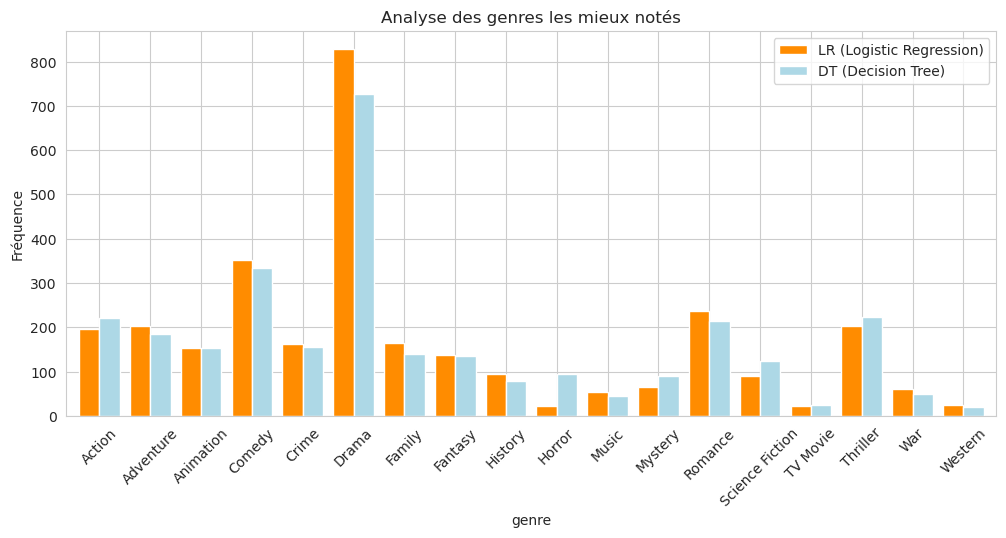

In [72]:
compare_df = pd.DataFrame({
    'LR': genre_counts_lr,
    'DT': genre_counts_dt
}).fillna(0)

colors = ["darkorange", "lightblue"]

compare_df.plot(
    kind='bar',
    figsize=(12, 5),
    width=0.8,
    color=colors  
)

plt.title("Analyse des genres les mieux notés")
plt.ylabel("Fréquence")
plt.xticks(rotation=45)
plt.legend(["LR (Logistic Regression)", "DT (Decision Tree)"])
plt.show()

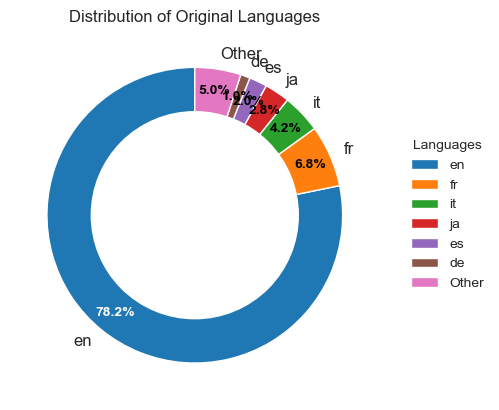

In [48]:
language_counts = data['original_language'].value_counts()

threshold = language_counts.sum() * 0.01  # 1% threshold
mask = language_counts > threshold
tail = language_counts.loc[~mask]
language_counts = language_counts.loc[mask]
language_counts['Other'] = tail.sum()


fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(language_counts, labels=language_counts.index,
                                  autopct='%1.1f%%', startangle=90, pctdistance=0.85,
                                  colors=sns.color_palette("tab10", len(language_counts)))


centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)


plt.setp(texts, size=12)
plt.setp(autotexts, size=10, color="black", weight="bold")
autotexts[0].set_color('white')  

ax.set_title('Distribution of Original Languages')
plt.legend(title='Languages', loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False)

plt.show()

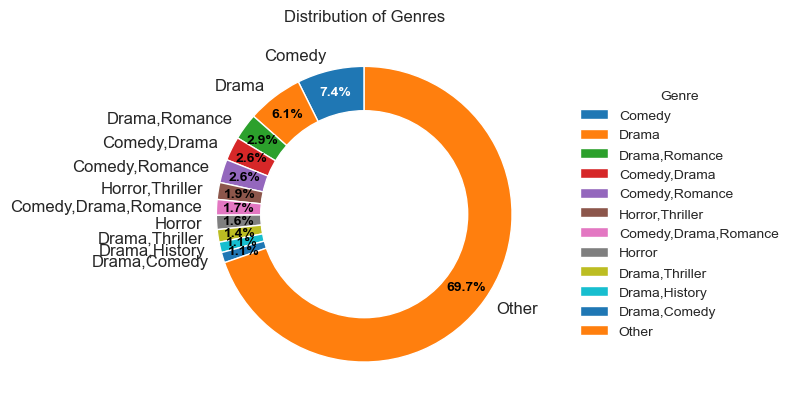

In [49]:
language_counts = data['genre'].value_counts()

threshold = language_counts.sum() * 0.01  # 1% threshold
mask = language_counts > threshold
tail = language_counts.loc[~mask]
language_counts = language_counts.loc[mask]
language_counts['Other'] = tail.sum()


fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(language_counts, labels=language_counts.index,
                                  autopct='%1.1f%%', startangle=90, pctdistance=0.85,
                                  colors=sns.color_palette("tab10", len(language_counts)))


centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)


plt.setp(texts, size=12)
plt.setp(autotexts, size=10, color="black", weight="bold")
autotexts[0].set_color('white')  

ax.set_title('Distribution of Genres')
plt.legend(title='Genre', loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False)

plt.show()

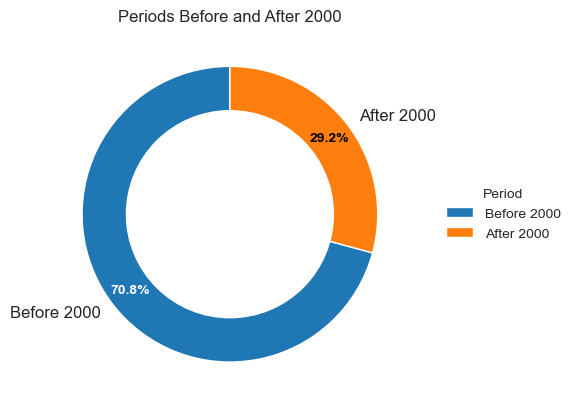

In [53]:
def categorize_by_2000(date):
    if pd.isna(date):
        return 'Unknown'  
    return 0 if date.year < 2000 else 1

data['period'] = data['release_date'].apply(categorize_by_2000)
period_counts = data['period'].value_counts()


fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(period_counts, labels=['Before 2000', 'After 2000'],
                                  autopct='%1.1f%%', startangle=90, pctdistance=0.85,
                                  colors=sns.color_palette("tab10", len(period_counts)))

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

plt.setp(texts, size=12)  
plt.setp(autotexts, size=10, color="black", weight="bold") 
autotexts[0].set_color('white')  

ax.set_title('Periods Before and After 2000')
plt.legend(title='Period', loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False)

plt.show()